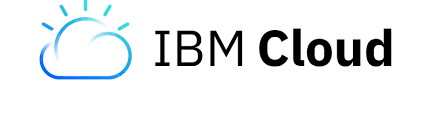

## Setup your notebook file stystem on Watson Studio

All of the notebooks in these courses are written to run locally on your computer running a Jupyter notebook server.  If you wish to run the notebooks in Watson Studio in the IBM Cloud, you will need to add some modifications to each notebook.

Why?  Because once you import a course notebook and the data files for that notebook into a Watson Studio project, the data files are no longer available to the notebook! 
This is simply due to the fact that the imported data files are stored in an IBM Cloud Object Storage (COS) bucket.  The notebook does not have access to those objects in the COS bucket.  Thus, if you import a notebook and its data files into a Studio project then try to run it, the notebook will return "File not found" errors. 
In order to make the data files available to your notebook, you will need to run some code in your notebook to: 

1 - Access the correct COS bucket <br>
2 - Read your data file from the bucket into a byte stream object <br>
3 - Write that byte stream object to the virtual disk of the container running the notebook. 

First, in order to access the correct COS bucket, you need to <b>insert a project token</b>. To do so, click the <b>More</b> icon on your notebook toolbar and then click <b>Insert project token</b>.

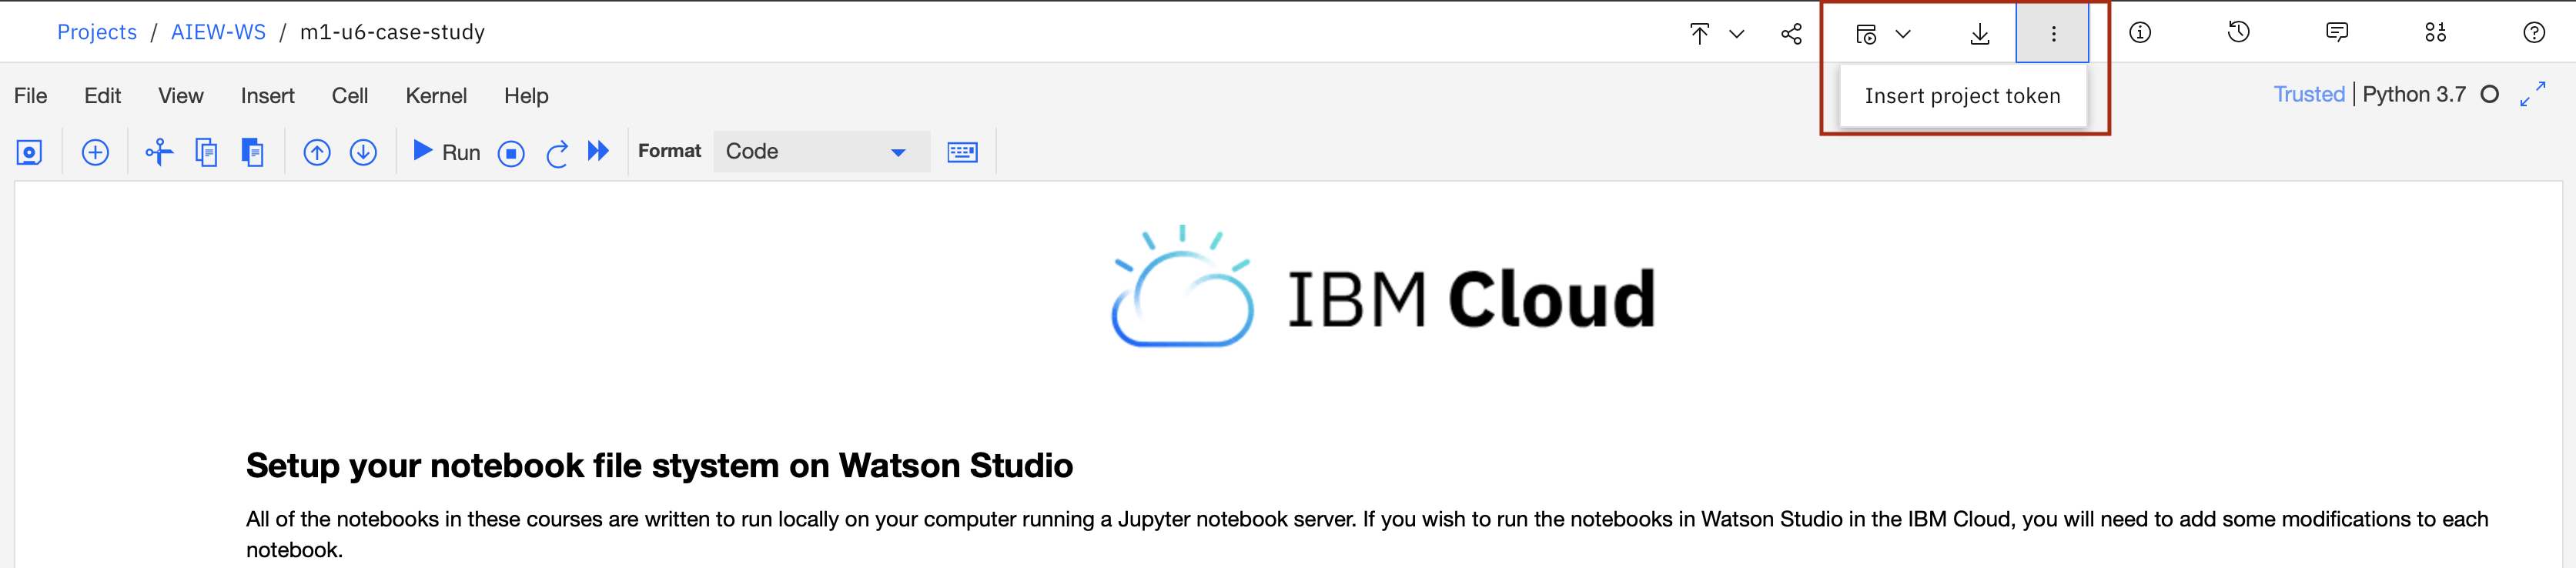

A new cell will be added on top of your notebook. Running this cell allows to create the <b>"project"</b> object that will allow us to access the COS bucket. After running this new cell, run the following two coding cells to write the data files in the virtual disk of the container running this notebook. You are ready to start the study case !

In [1]:
DATA_DIR = os.path.join(pc.home, 'data')
SCRIPTS_DIR = os.path.join(pc.home, 'scripts')
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
if not os.path.exists(SCRIPTS_DIR):
    os.makedirs(SCRIPTS_DIR)

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200908220048-0005
KERNEL_ID = 0573f8f1-d468-4336-979c-7504e227d8f6


In [2]:
open(os.path.join(DATA_DIR, 'sherlock-holmes.txt'), 'wb').write(project.get_file('sherlock-holmes.txt')[0]['file_content'].read())

607788

# Spark introduction

In [3]:
import re
import os
from collections import Counter
import numpy as np
import pandas as pd
from termcolor import cprint
import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 11
LARGE_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

def slide_print(text, color='white'):
    cprint(text, color, 'on_grey')
    
DATA_DIR = "./data"

Sometimes a single machine simple cannot perform a given task fast enough.  Sometimes there are too many tasks for a single machine to properly handle and yet othertimes there are so much data that the data must be distributed across resources.  These scenarios describe several of the situations where the use of Apache Spark has the potential to directly impact a business opportunity.  Whether you are working with spark locally, on Watson Studio, from within Docker or as part of a computer cluster the basics will cover in this video will still apply.

## High performance computing

* <span style="color:orange">Symmetric multiprocessing</span> -Two or more identical processors connected to a single unit of memory.
* <span style="color:orange">Distributed computing</span> - Processing elements are connected by a network.
* <span style="color:orange">Cluster computing</span> - Group of coupled computers that work together in a way that they can be viewed as a single system.
* <span style="color:orange">Massive parallel processing</span> - Many networked processors usually > 100 used to perform computations in parallel.
* <span style="color:orange">Grid computing</span> - Distributed computing making use of a middle layer to create a `virtual super computer`.

> Spark is a cluster-computing framework. When you compare it to hadoop it essentially competes with which the MapReduce component of the Hadoop ecosystem.

There are many types of high performance computing environments.  READ STATEMENT.  Spark does not have its own distributed filesystem, but can use the Hadoop Distributed File System or HDFS.  Spark uses memory and can use disk for processing, whereas MapReduce has strictly disk-based processing.

### Spark Applications (overview)

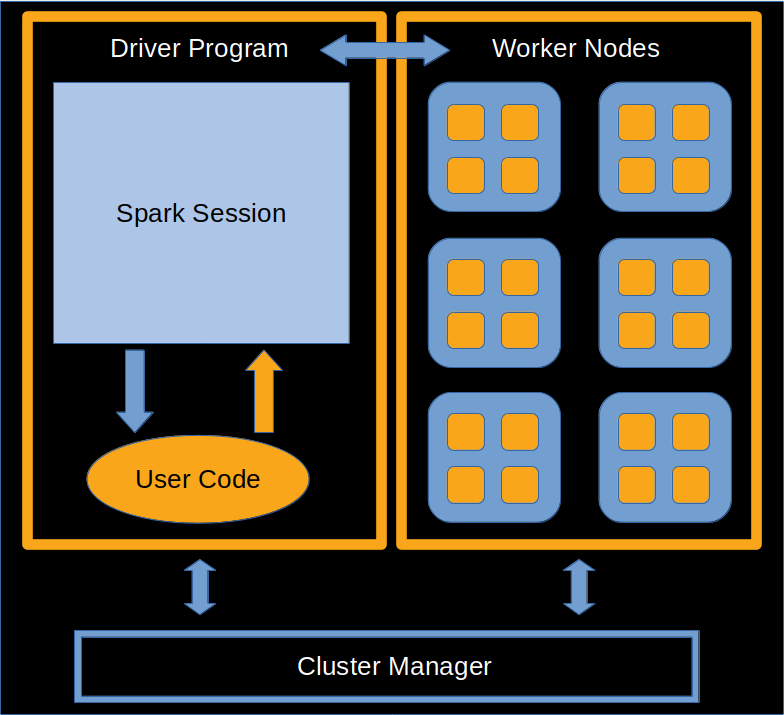


> Spark applications run as independent sets of processes on a cluster, coordinated by the SparkContext object in your main program (called the driver program).

Here we have a diagram of Spark Application.  When we start a spark environment a Spark Session is first created and this manages the driver process.  The driver program can be controlled using API's in Scala, Python SQL, Java and R. The worker nodes on the right are usually distinct machines. Executors are the worker nodes' processes, each in charge of running and individual task and they are shown as the orange squares on the worker nodes. One cluster configuration is to assign several cores to each executor leaving one for additional overhead.  The cluster manager, shown on the bottom, which is often YARN, Mesos or Kubernetes helps coordinate between the driver program and worker nodes.

### Spark Applications (general process)

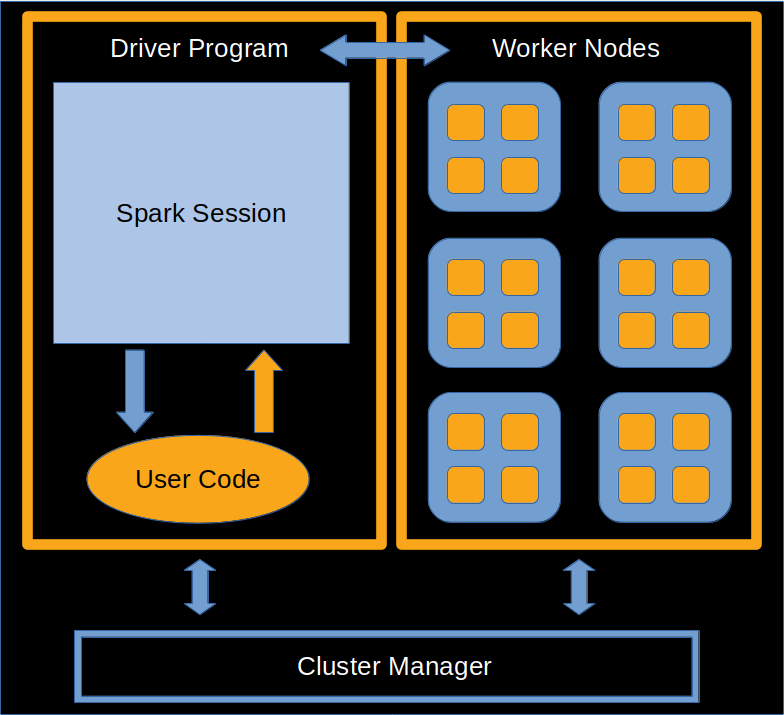

Spark applications are run as an independent sets of processes on a cluster coordinated by the SparkContext object in your main program. Each application gets its own executor processes, which remains allocated for the duration of application.  The driver program, that encapsulates both the SparkContext and the SparkSession is used to submit Spark Applications in Spark .The driver program, once it is given instructions in the form of user code will then ask the cluster manager to launch executors. 

## SparkSession

* SparkContext
* SQLContext
* HiveContext
* StreamingContext

In [4]:
import pyspark as ps
import random

spark = (ps.sql.SparkSession.builder
        .appName("sandbox")
        .getOrCreate()
        )

slide_print(spark.version)

sc = spark.sparkContext

for attribute in sc._conf.getAll():
    slide_print(attribute)

2.4.6
('spark.dynamicAllocation.enabled', 'false')
('spark.eventLog.enabled', 'true')
('spark.network.crypto.keyLength', '256')
('spark.shuffle.service.enabled', 'false')
('spark.network.crypto.enabled', 'true')
('spark.driver.memory', '4g')
('spark.executor.extraClassPath', '/usr/local/share/jupyter/kernels/scala/lib/*:/home/spark/shared/user-libs/spark2/*:/home/spark/shared/user-libs/common/*:/home/spark/shared/user-libs/connectors/*:/opt/ibm/connectors/db2/*:/opt/ibm/connectors/others-db-drivers/*:/opt/ibm/third-party/libs/spark2/*:/opt/ibm/third-party/libs/common/*:/opt/ibm/third-party/libs/connectors/*')
('spark.authenticate.enableSaslEncryption', 'true')
('spark.authenticate.secret', '23cff02b-0220-4bd2-b0b8-6b882007e248')
('spark.ui.port', '4040')
('spark.driver.port', '33704')
('spark.ui.killEnabled', 'false')
('spark.app.id', 'app-20200908220048-0005')
('spark.hadoop.fs.stocator.glob.bracket.support', 'true')
('spark.driver.extraJavaOptions', ' -Dderby.system.home=/home/spark/

Prior to Spark 2.0 there were multiple points of entry for a Spark application, including: SparkContext, SQLContext, HiveContext, and the StreamingContext.  More recent versions of Spark combine all of these objects into a single point of entry that can be used for all Spark applications.  The SparkContext is a child process of the SparkSession. In this cell first we create a SparkSession using the SparkSession builder then we show how to access the Spark Context. Using the SparkContext we show here how to print some of the configuration properties.

## RDD (Resilient Distributed Dataset) 

### An example workflow

1. Create the enviromnent to run spark from python
2. Extract RDDs or DataFrames from files
3. Carry out transformations
4. Execute actions to obtain values (local objects in python)

### The RDD API has two types of operations:

* <span style="color:orange">Transformations</span> - Define a new dataset based on a previous one
* <span style="color:orange">Actions</span> - launch a job for execution on a cluster

In [5]:
text_file = sc.textFile(os.path.join(DATA_DIR, "sherlock-holmes.txt"))
counts = text_file.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b)
slide_print(type(text_file))  # show that the data are read into an RDD
results = counts.collect()    # output the content in python (CAUTION)
slide_print(results[:7])      # print output

<class 'pyspark.rdd.RDD'>
[('', 3136), ('Project', 81), ('The', 272), ('of', 2723), ('Arthur', 14), ('Conan', 4), ('is', 1074)]


Theses four enumerated steps represent an example workflow.  The code version of these steps are shown just below, with the exception of setting up the environment which we just did.  Spark revolves around the concept of resilient distributed datasets or RDDs.  An RDD is a fault-tolerant collection of elements that can be operated on in parallel. The RDD API, uses two types types of operations: transformations and and actions.  On top of Spark’s RDD API, high level APIs are provided, including the DataFrame API and Machine Learning API, both of which we will cover in this course.  The text_file is an RDD that once subjected to a chain of transformations is used to create counts, another RDD.  The action we use here is 'collect', which brings the data back into Python and it is something you should exercise caution with, especially when working with very large datasets.

### To keep in mind

 * Transformations are the main way of expressing business logic in Spark.
 * Spark doesn't apply the transformation right away, it just builds on the DAG
 * Transformations can be chained together
 *  RDDs are an immutable distributed collection of elements of your data, partitioned across nodes in your cluster that can be operated on in parallel


In [6]:
# an RDD from a an array
rand_nums = np.random.randint(0,500,500000)
rdd = sc.parallelize(rand_nums) 
divis_by_3 = rdd.filter(lambda x: x % 3 == 0)

total1 = rdd.count()
total2 = divis_by_3.count()

print("total divisible by 3: {}/{}".format(total2,total1))

total divisible by 3: 166594/500000


There are several important things to remember about RDDs.  The first is that they use what is known as lazy evaluation.  This means that Spark will wait until the very last moment to execute your transformations.  It does this by constructing a Direct Acyclic Graph or DAG of the transformations.  When an action like count or collect is called the task is sent for execution.  Here we show another example on an RDD, but this time we create it using a numpy array with the parallelize function.  The transformation is a simple filter and the actions are obtain counts rather than all of the data since we generally want to avoid pulling all data into local memory unless we have too.

## Spark-submit

In [7]:
%%writefile ./scripts/calculate-pi.py

import pyspark as ps
import os
import random
DATA_DIR = "./data"

spark = (ps.sql.SparkSession.builder
        .appName("get-pi")
        .getOrCreate()
        )

sc = spark.sparkContext
random.seed(1)

def sample(p):
    x, y = random.random(), random.random()
    return 1 if x*x + y*y < 1 else 0

count = (sc.parallelize(range(0, 10000000))
           .map(sample)
           .reduce(lambda a, b: a + b)
        )

result = {"pi": (4.0 * count / 10000000)}
print(result, file=open(os.path.join(DATA_DIR, 'calculate-pi-out.txt'), 'w'))

Overwriting ./scripts/calculate-pi.py


We can now run the script that we just created as a spark job directly using the spark-submit command.

In [8]:
# The linux virtual machine on which this notebook is built does not recognize spark-submit as a command line
# therefore, we need to locate the home directory of spark and directly call spark-submit from this directory.
! export SPARK_HOME=$PATH:/opt/ibm/spark
! ${SPARK_HOME}/bin/spark-submit ./scripts/calculate-pi.py

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/ibm/spark/jars/slf4j-log4j12-1.7.16.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/ibm/image-libs/spark2/tika-app-1.14.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
20/09/08 22:01:09 [WARN] o.a.h.u.NativeCodeLoader - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
20/09/08 22:01:11 [INFO] o.s.j.u.log - Logging initialized @3970ms
20/09/08 22:01:11 [INFO] o.s.j.s.Server - jetty-9.3.z-SNAPSHOT, build timestamp: unknown, git hash: unknown
20/09/08 22:01:12 [INFO] o.s.j.s.Server - Started @4094ms
20/09/08 22:01:12 [WARN] o.a.s.u.Utils - Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
20/09/08 22:01:12 [INFO] o.s.j.s.AbstractConnector - Starte

Once the spark jobs has run, a text file (calculate-pi-out.txt) has been create in the data folder with the output of the job.

In [9]:
import ast
with open(os.path.join(DATA_DIR, 'calculate-pi-out.txt')) as file:  
    results = file.read() 
    results = ast.literal_eval(results)
    
slide_print(results)

{'pi': 3.1401612}


Applications can be submitted to a cluster of any type using the command spark-submit and an accompanying script. The writefile magic function shown here saved the code in the cell as a python script to be called by spark-submit.  The file calculate-pi, unsurprisingly calculates pi, but more importantly it shows an example of how to map a custom function over an RDD.  Spark-submit can be run from the command line as shown.  Generally, it is called with a number of options using a bash file, but it can be called using all the defaults as shown here. Once the script is run it will produce the outfile that is being printed here.  This procedure could be used to make a prediction using a machine learning model that has been tuned, trained and saved. 